<h1 style="text-align:center;">Univariate and multivariete analysis, backtesting</h1>

In [2]:
import os
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import bartlett, fligner, levene

In [3]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize': (14, 9)})
sns.set(font_scale=1.5)

In [4]:
variables = ["petrol", "diesel", "eur", "gbp"]
colors = {"petrol": "blueviolet", "diesel": "royalblue", "eur": "deepskyblue", "gbp": "teal"}

<h1 style="text-align:center;">Data</h1>

In [5]:
def price_loader(source):
    if source in  ["diesel", "petrol"]:
        df = pd.read_csv(os.path.join("data", "full", f"{source}.csv"))[["date", "price"]]
        df["date"] = pd.to_datetime(df.date)
        df = df[df["price"] > 0]
        return df[df["date"] >= "2012"]
    df = pd.read_csv(os.path.join("data", "full", f"{source}.csv"))[["Date", "Open"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df.date)
    return df[df["date"] >= "2012"]


def get_log_returns(df):
    date = pd.to_datetime(df["date"]).to_numpy(dtype='datetime64[D]')
    prices = df["price"].to_numpy()
    diff = np.diff(date).astype('float64')
    log_returns = np.diff(np.log(prices)) / (diff / 365.25) 
    return pd.DataFrame({'date': date[1:], 'log_returns': log_returns})
    

def plotter(source, figsize=(14, 9)):
    df1 = price_loader(source)
    df2 = get_log_returns(df1)
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.lineplot(x="date", y="price", data=df1, ax=ax[0], color=colors[source])
    sns.lineplot(x="date", y="log_returns", data=df2, ax=ax[1], lw=1, color=colors[source])
    ax[0].set(xlabel="time", ylabel="price")
    ax[1].set(xlabel="time", ylabel="log returns")
    ax[0].tick_params(axis='x', labelrotation = 45)
    ax[1].tick_params(axis='x', labelrotation = 45)
    fig.suptitle(source, fontsize=20)
    return fig

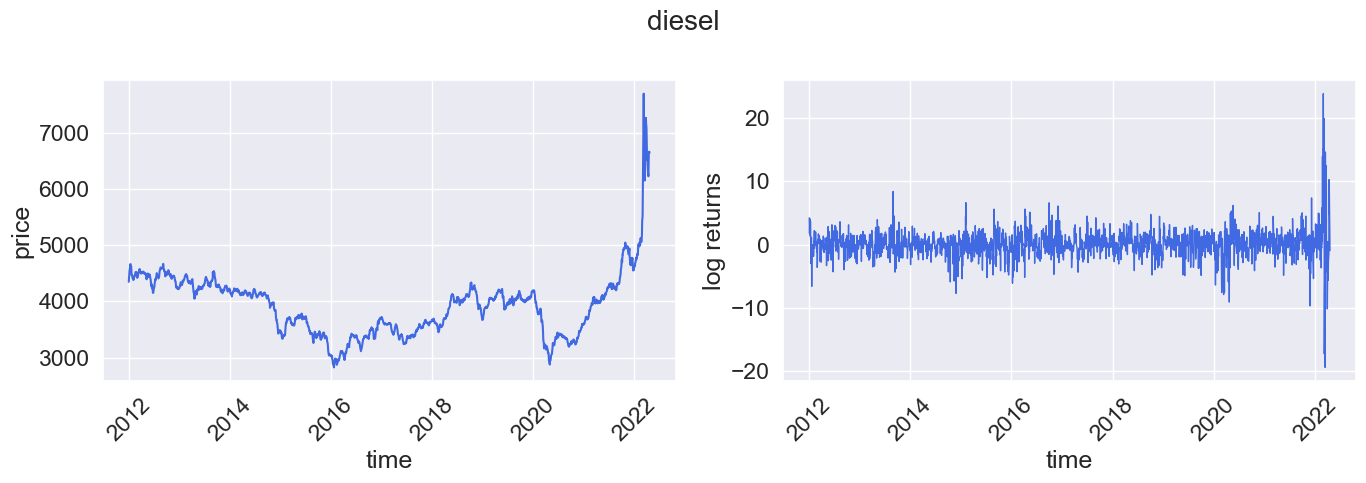

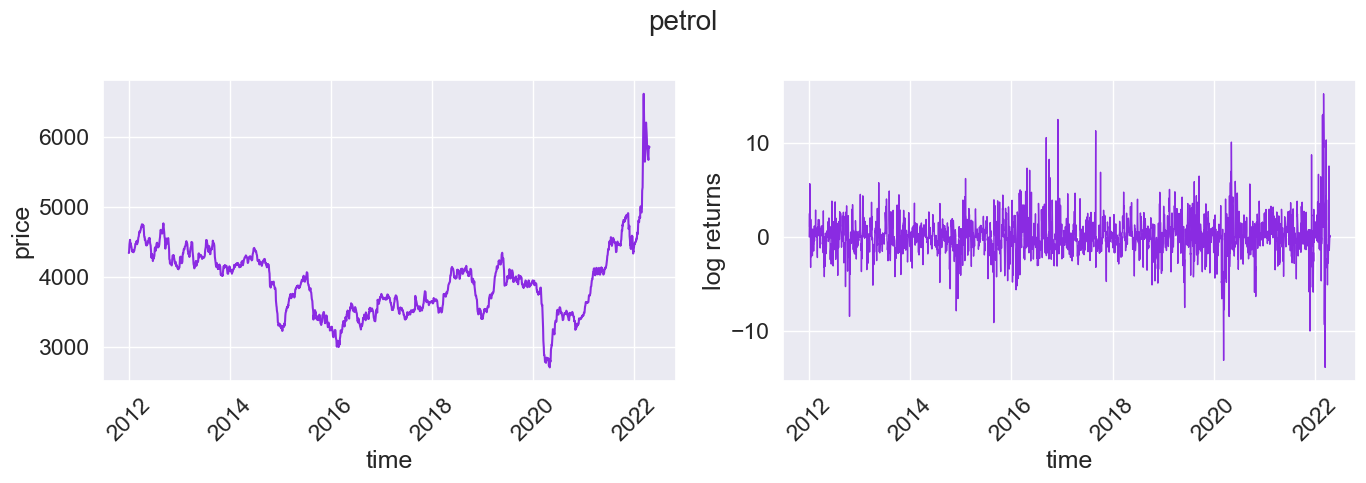

In [6]:
for i in ["diesel", "petrol"]:
    fig = plotter(i, figsize=(14, 5))
    plt.tight_layout()
    plt.show()

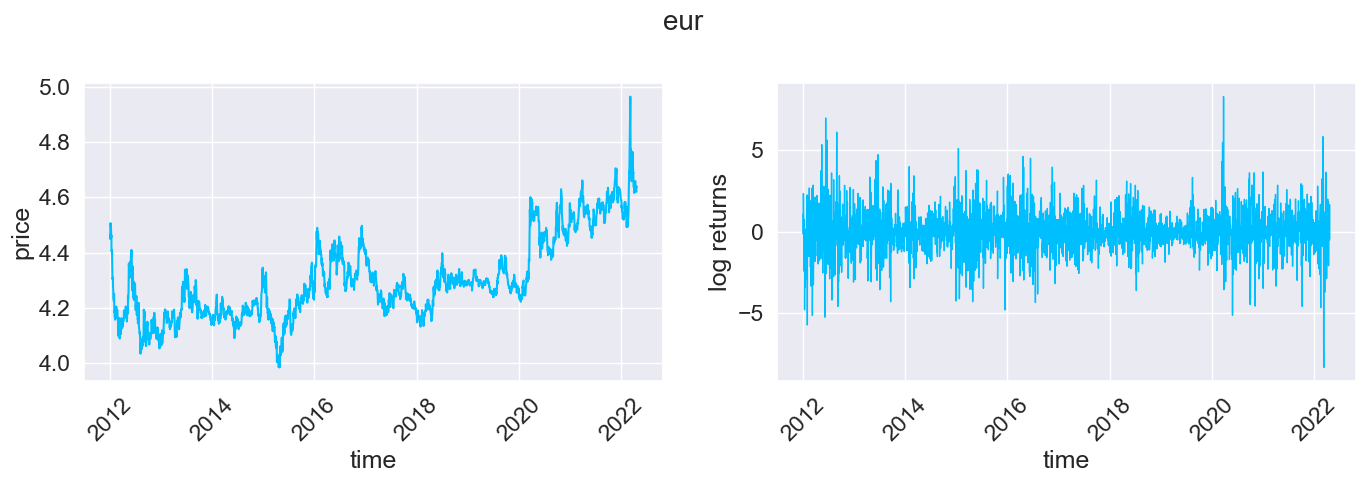

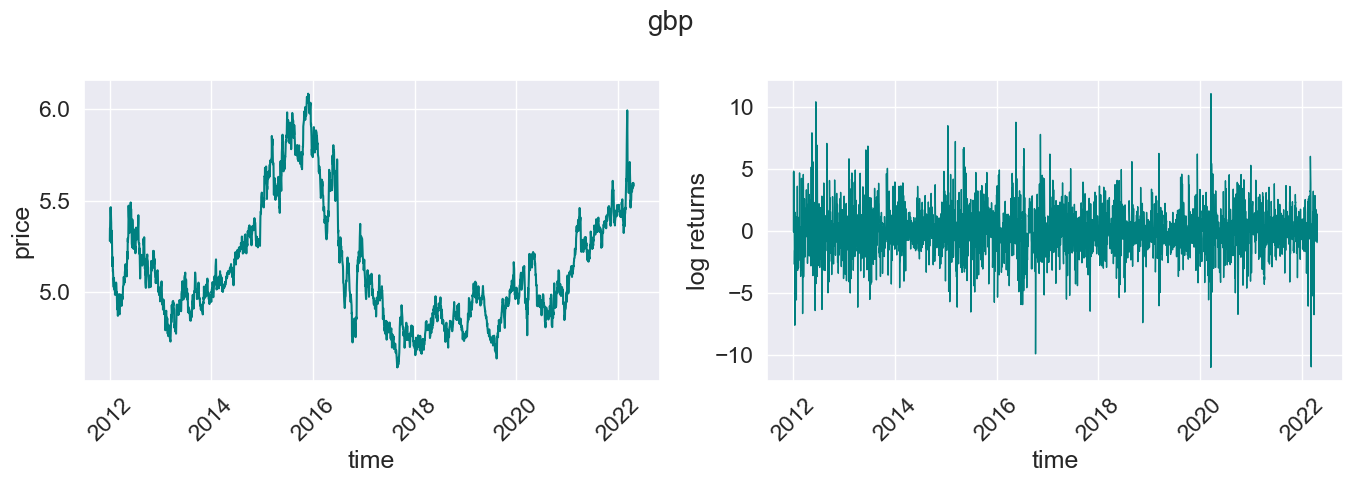

In [6]:
for i in ["eur", "gbp"]:
    fig = plotter(i, figsize=(14, 5))
    plt.tight_layout()
    plt.show()

<h2 style="text-align:center">Univariate analysis</h2>

In [9]:
# distributions fit functions, cdf and pdf plots, measures
def pconv(alpha, beta, mu, sigma):
    return (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)


def norm_rv(date, data):
    diff = (date[1:] - date[:-1]).astype('float64')
    logret = np.log(data[1:] / data[:-1]) / (diff / 365.25)

    return stats.norm(np.mean(logret), np.std(logret))


def stable_rv(date, data):
    diff = (date[1:] - date[:-1]).astype('float64')
    logret = np.log(data[1:] / data[:-1]) / (diff / 365.25)

    alpha, beta, loc, scale = pconv(*stats.levy_stable._fitstart(logret))

    return stats.levy_stable(alpha = alpha, beta = beta, loc = loc, scale = scale)


def compare_pdf(date, data, rv, color="royalblue", color2="red", label="variable", label2="pdf", plot_hist=True):
    diff = (date[1:] - date[:-1]).astype('float64')
    logret = np.log(data[1:] / data[:-1]) / (diff / 365.25)

    if plot_hist:
        sns.histplot(logret, stat = 'density', color=color, label=label)

    xs = np.linspace(min(logret), max(logret), 1001)
    ys = rv.pdf(xs)
    sns.lineplot(x = xs, y = ys, color=color2, label=label2)


def compare_cdf(date, data, rv, color="royalblue", color2="red", label="ecdf", label2="cdf"):
    diff = (date[1:] - date[:-1]).astype('float64')
    logret = np.log(data[1:] / data[:-1]) / (diff / 365.25)

    sns.ecdfplot(logret, color=color, label=label)

    xs = np.linspace(min(logret), max(logret), 1001)
    ys = rv.cdf(xs)
    sns.lineplot(x = xs, y = ys, color=color2, label=label2)


def markdown_printer(variable, dictionary):
    df = pd.DataFrame.from_dict(dictionary)
    s = df.to_markdown()

    print(f'### {variable}')
    print('\n'.join(map(lambda x: x[5:], s.split("\n"))))


def measures(date, data, rv):
    diff = (date[1:] - date[:-1]).astype('float64')
    logret = np.log(data[1:] / data[:-1]) / (diff / 365.25)

    variable = 'Basic measures'
    dictionary =  {'measure': ['mean', 'std', 'median', 'iqr'], 
        'nonparametric': [np.mean(logret), np.std(logret), np.median(logret), stats.iqr(logret)], 
        'parametric': [rv.mean(), rv.std(), rv.median(), rv.ppf(0.75) - rv.ppf(0.25)]}

    markdown_printer(variable, dictionary)

    variable = 'Quantiles'
    dictionary =  {'q': [0.05, 0.10, 0.5], 
        'nonparametric': [np.quantile(logret, 0.05), np.quantile(logret, 0.10), np.quantile(logret, 0.50)], 
        'parametric': [rv.ppf(0.05), rv.ppf(0.10), rv.ppf(0.50)]}

    markdown_printer(variable, dictionary)

    variable = 'CDF values'
    dictionary =  {'R_q': [-1, 0.0, 1], 
        'nonparametric': [np.count_nonzero(logret <= -1) / np.size(logret), np.count_nonzero(logret <= 0) / np.size(logret), np.count_nonzero(logret <= 1) / np.size(logret)], 
        'parametric': [rv.cdf(-1), rv.cdf(0), rv.cdf(1)]}

    markdown_printer(variable, dictionary)

### Diesel

In [10]:
df = pd.read_csv(os.path.join('data', 'fit', 'diesel_fit.csv'))
date = pd.to_datetime(df.date).to_numpy(dtype = 'datetime64[D]')
data = df.price.to_numpy() / 1000

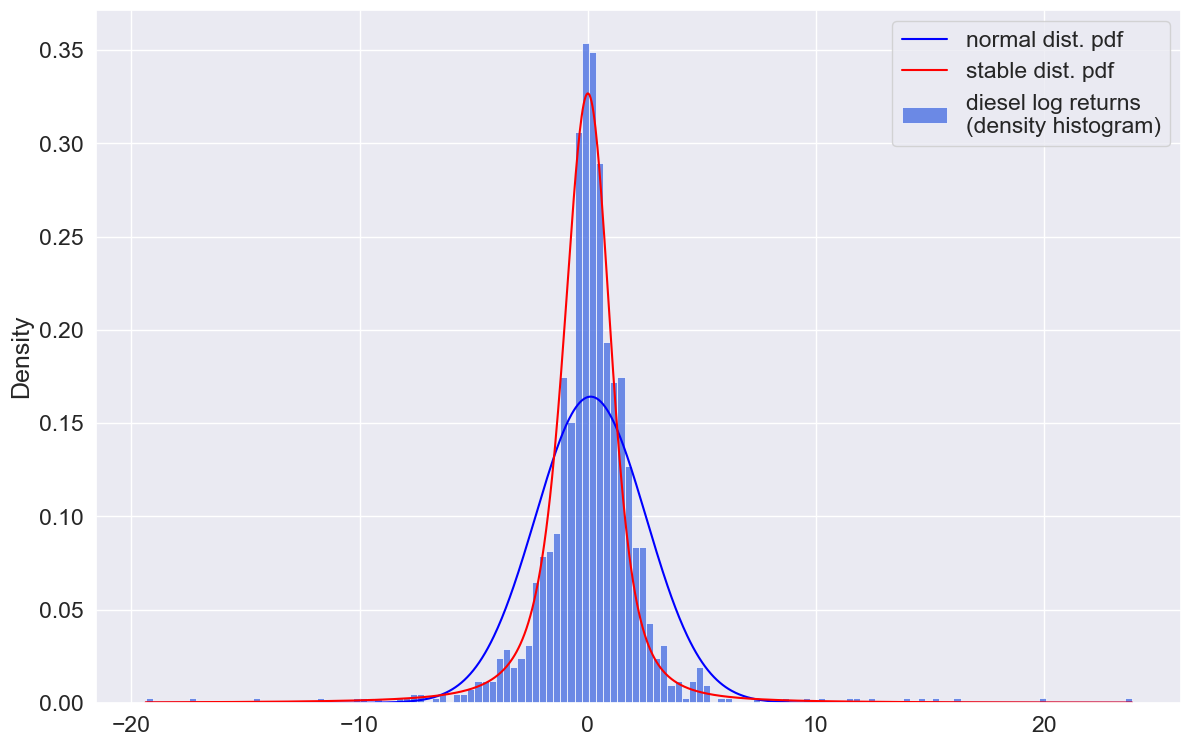

In [11]:
compare_pdf(date, data, norm_rv(date, data), color=colors["diesel"], color2="blue",
            label="diesel log returns \n(density histogram)", label2="normal dist. pdf")

compare_pdf(date, data, stable_rv(date, data), 
            label="diesel log returns \n(density histogram)", label2="stable dist. pdf", plot_hist=False)

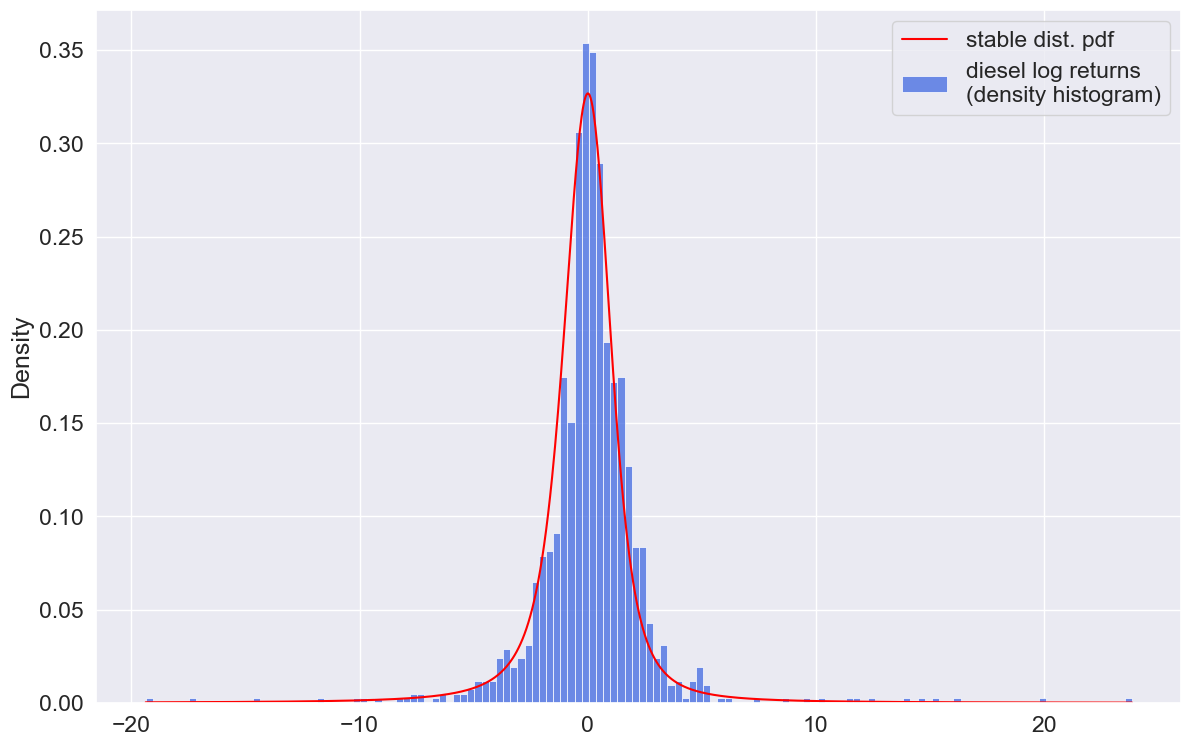

In [10]:
compare_pdf(date, data, stable_rv(date, data), color=colors["diesel"],
            label="diesel log returns \n(density histogram)", label2="stable dist. pdf")

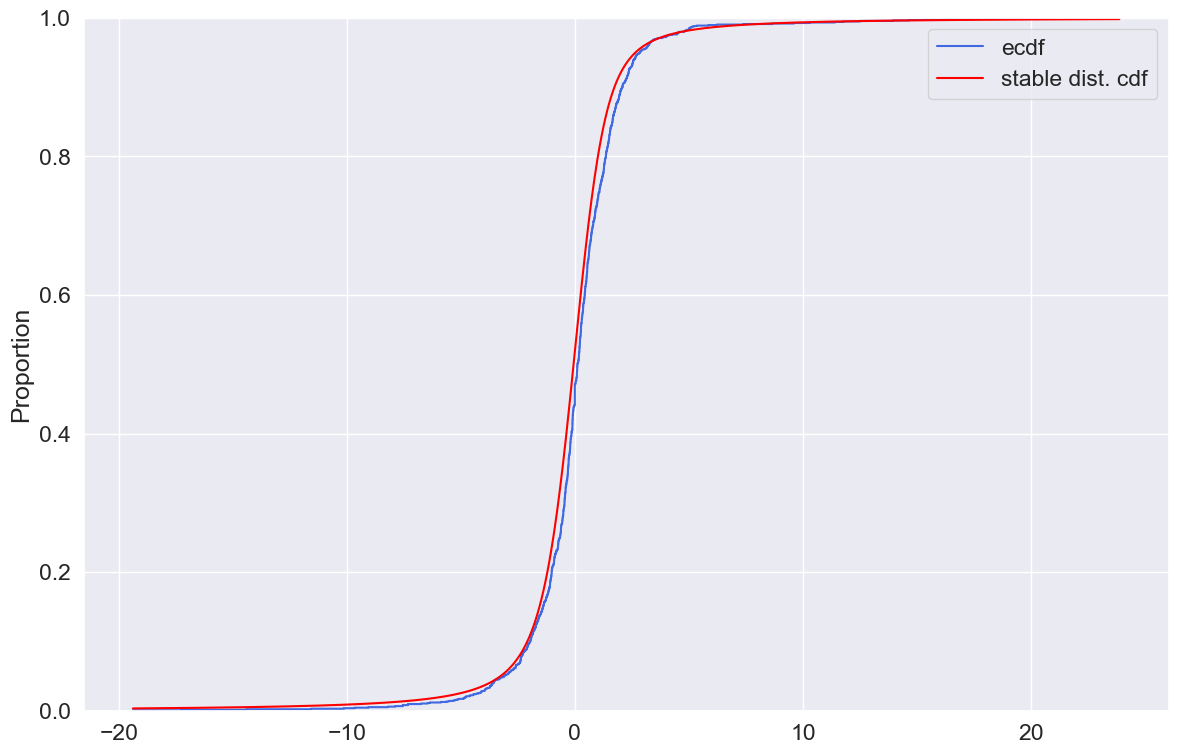

In [11]:
compare_cdf(date, data, stable_rv(date, data), color=colors["diesel"], 
            label2="stable dist. cdf")

In [12]:
measures(date, data, stable_rv(date, data))

### Basic measures
| measure   |   nonparametric |   parametric |
|:----------|----------------:|-------------:|
| mean      |        0.134834 |   -0.185981  |
| std       |        2.42927  |  inf         |
| median    |        0.113046 |   -0.0549921 |
| iqr       |        1.73343  |    1.72755   |
### Quantiles
|    q |   nonparametric |   parametric |
|-----:|----------------:|-------------:|
| 0.05 |       -3.10249  |   -3.26011   |
| 0.1  |       -1.95086  |   -2.08537   |
| 0.5  |        0.113046 |   -0.0549921 |
### CDF values
|   R_q |   nonparametric |   parametric |
|------:|----------------:|-------------:|
|    -1 |        0.205397 |     0.238535 |
|     0 |        0.471514 |     0.517959 |
|     1 |        0.737631 |     0.797871 |


### Petrol

In [12]:
df = pd.read_csv(os.path.join('data', 'fit', 'petrol_fit.csv'))
date = pd.to_datetime(df.date).to_numpy(dtype = 'datetime64[D]')
data = df.price.to_numpy() / 1000

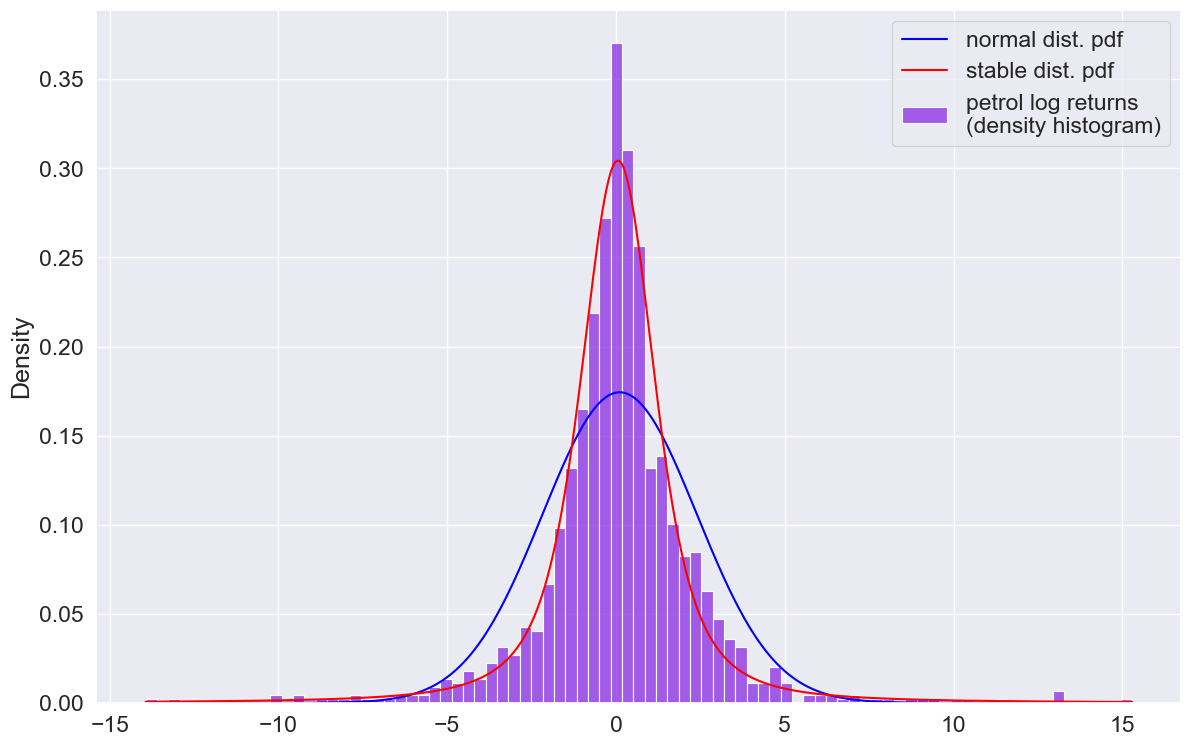

In [26]:
compare_pdf(date, data, norm_rv(date, data), color=colors["petrol"], color2="blue",
            label="petrol log returns \n(density histogram)", label2="normal dist. pdf")

compare_pdf(date, data, stable_rv(date, data), 
            label="petrol log returns \n(density histogram)", label2="stable dist. pdf", plot_hist=False)

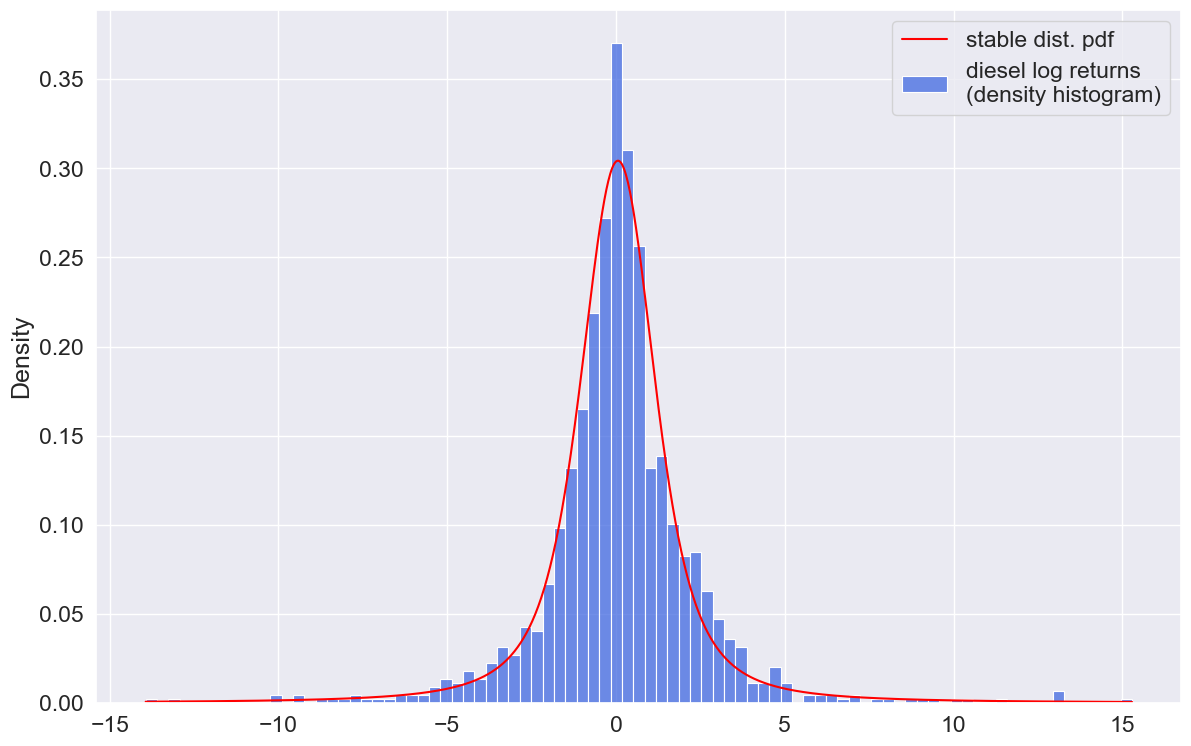

In [27]:
compare_pdf(date, data, stable_rv(date, data), color=colors["diesel"], 
            label="diesel log returns \n(density histogram)", label2="stable dist. pdf")

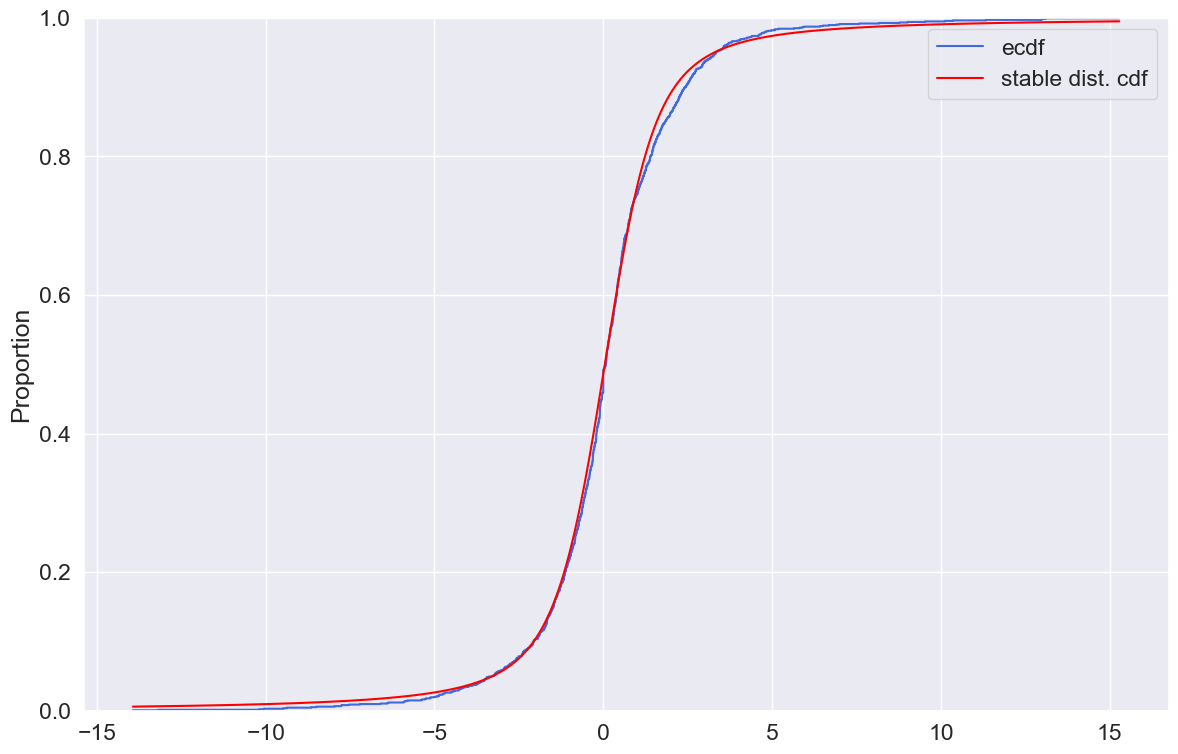

In [28]:
compare_cdf(date, data, stable_rv(date, data), color=colors["diesel"],
            label2="stable dist. cdf")

In [29]:
measures(date, data, stable_rv(date, data))

### Basic measures
| measure   |   nonparametric |   parametric |
|:----------|----------------:|-------------:|
| mean      |       0.109191  |    0.0230882 |
| std       |       2.28896   |  inf         |
| median    |       0.0758539 |    0.0464453 |
| iqr       |       1.86274   |    1.85958   |
### Quantiles
|    q |   nonparametric |   parametric |
|-----:|----------------:|-------------:|
| 0.05 |      -3.26498   |   -3.28409   |
| 0.1  |      -2.06196   |   -2.06201   |
| 0.5  |       0.0758539 |    0.0464453 |
### CDF values
|   R_q |   nonparametric |   parametric |
|------:|----------------:|-------------:|
|    -1 |        0.218891 |     0.227867 |
|     0 |        0.492504 |     0.485876 |
|     1 |        0.745877 |     0.755899 |


### EUR

In [30]:
df = pd.read_csv(os.path.join('data', 'fit', 'eur_fit.csv'))
data = df['Adj Close'].to_numpy()
date = pd.to_datetime(df.Date).to_numpy(dtype = 'datetime64[D]')

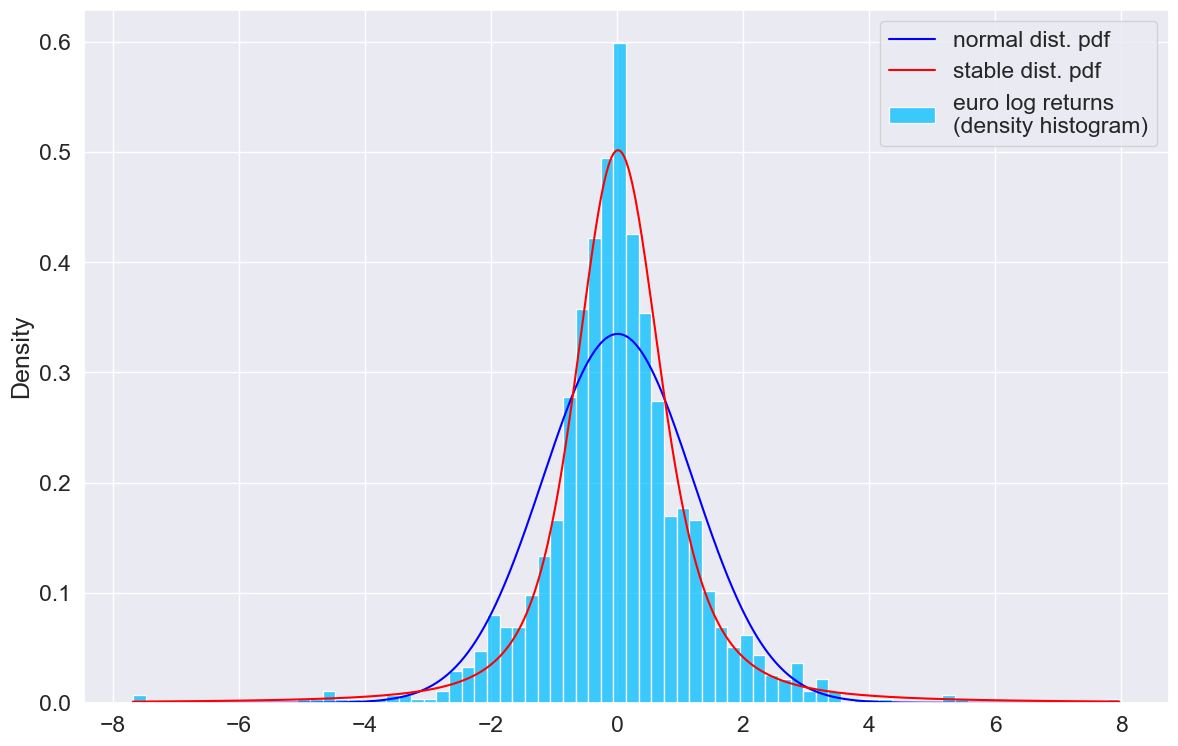

In [31]:
compare_pdf(date, data, norm_rv(date, data), color=colors["eur"], color2="blue",
            label="euro log returns \n(density histogram)", label2="normal dist. pdf")

compare_pdf(date, data, stable_rv(date, data), 
            label="petrol log returns \n(density histogram)", label2="stable dist. pdf", plot_hist=False)

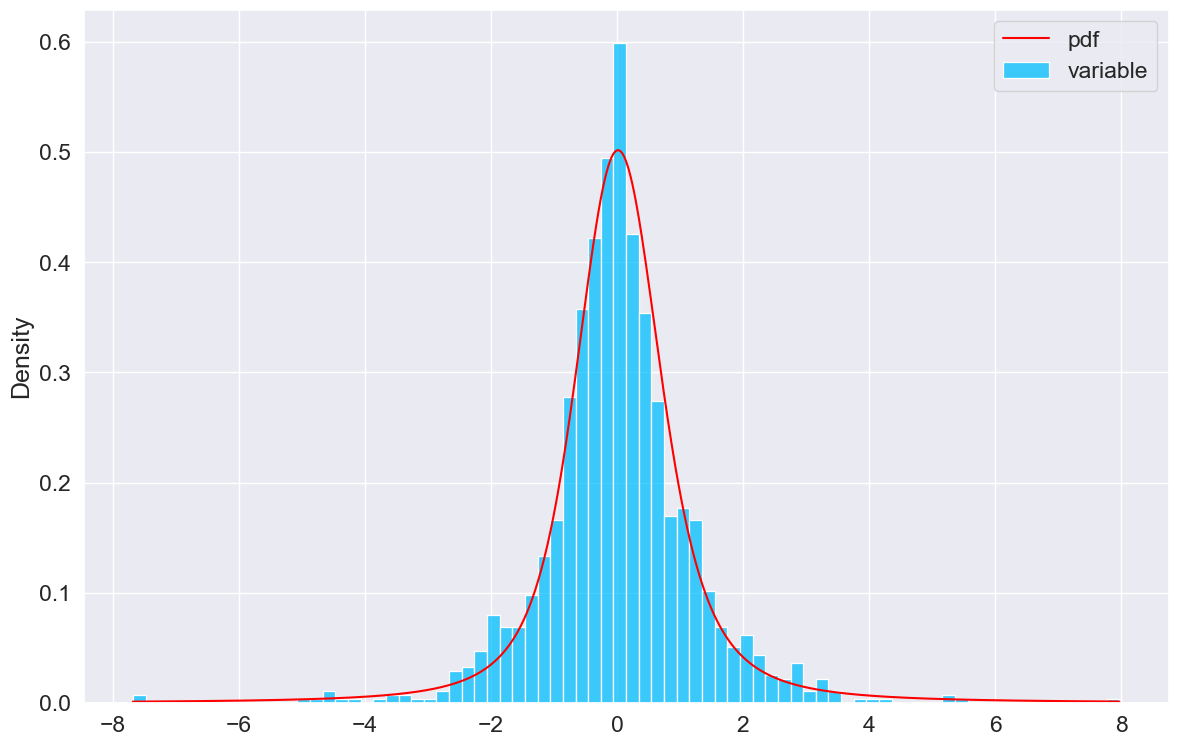

In [32]:
compare_pdf(date, data, stable_rv(date, data), color=colors["eur"])

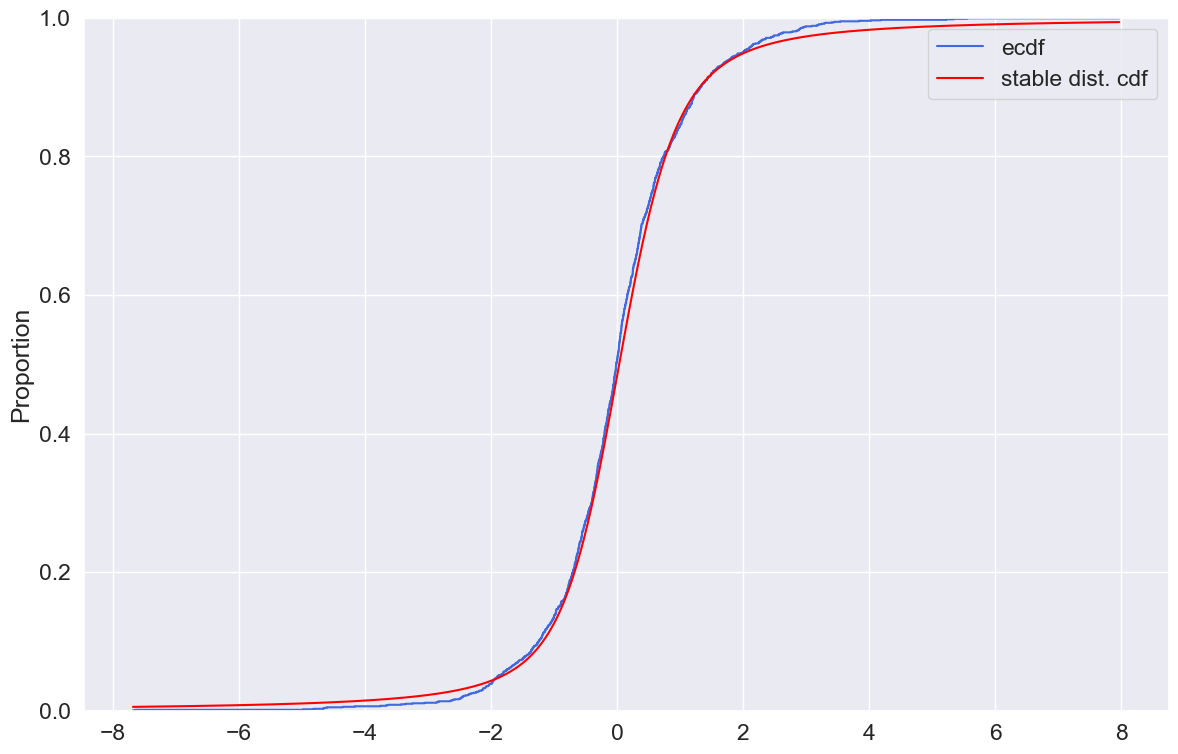

In [33]:
compare_cdf(date, data, stable_rv(date, data), color=colors["diesel"], 
            label2="stable dist. cdf")

In [34]:
measures(date, data, stable_rv(date, data))

### Basic measures
| measure   |   nonparametric |   parametric |
|:----------|----------------:|-------------:|
| mean      |       0.0116467 |    0.0710631 |
| std       |       1.19069   |  inf         |
| median    |      -0.011924  |    0.0346735 |
| iqr       |       1.1262    |    1.12327   |
### Quantiles
|    q |   nonparametric |   parametric |
|-----:|----------------:|-------------:|
| 0.05 |       -1.88119  |   -1.82636   |
| 0.1  |       -1.2413   |   -1.17571   |
| 0.5  |       -0.011924 |    0.0346735 |
### CDF values
|   R_q |   nonparametric |   parametric |
|------:|----------------:|-------------:|
|    -1 |        0.135409 |     0.125979 |
|     0 |        0.503983 |     0.4826   |
|     1 |        0.845764 |     0.853358 |


### GBP

In [35]:
df = pd.read_csv(os.path.join('data', 'fit', 'gbp_fit.csv'))
data = df['Adj Close'].to_numpy()
date = pd.to_datetime(df.Date).to_numpy(dtype = 'datetime64[D]')

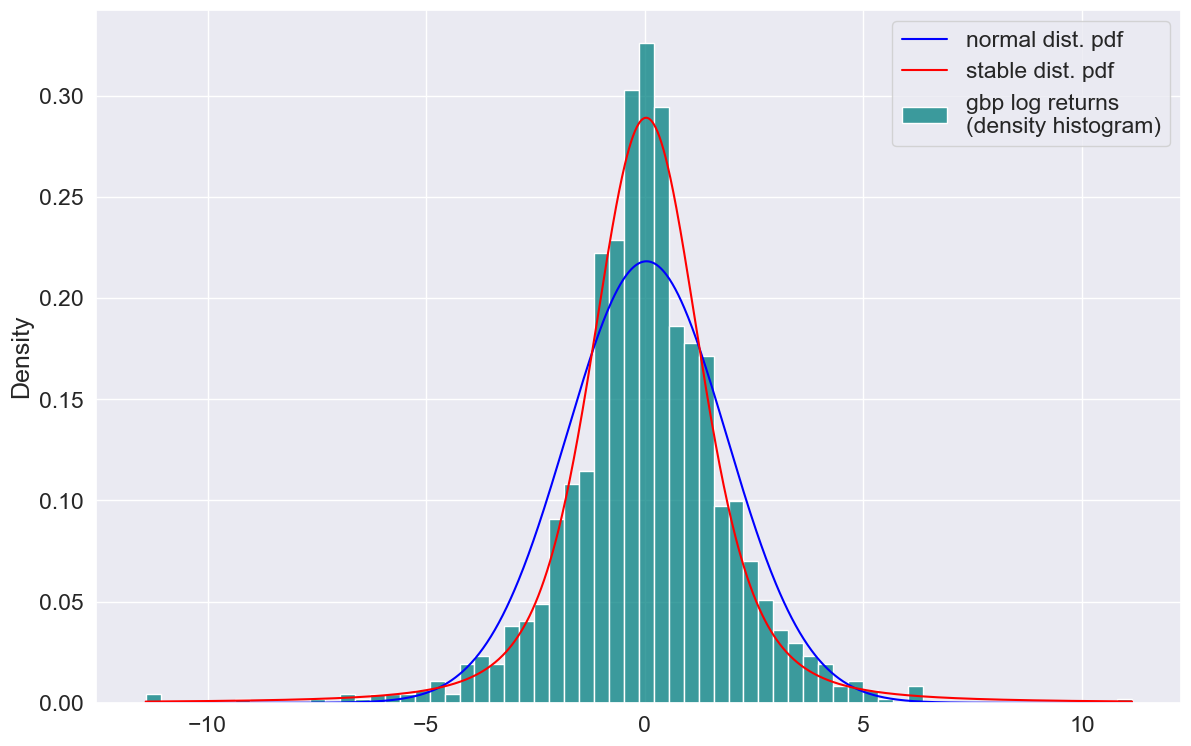

In [36]:
compare_pdf(date, data, norm_rv(date, data), color=colors["gbp"], color2="blue",
            label="gbp log returns \n(density histogram)", label2="normal dist. pdf")

compare_pdf(date, data, stable_rv(date, data), 
            label="petrol log returns \n(density histogram)", label2="stable dist. pdf", plot_hist=False)

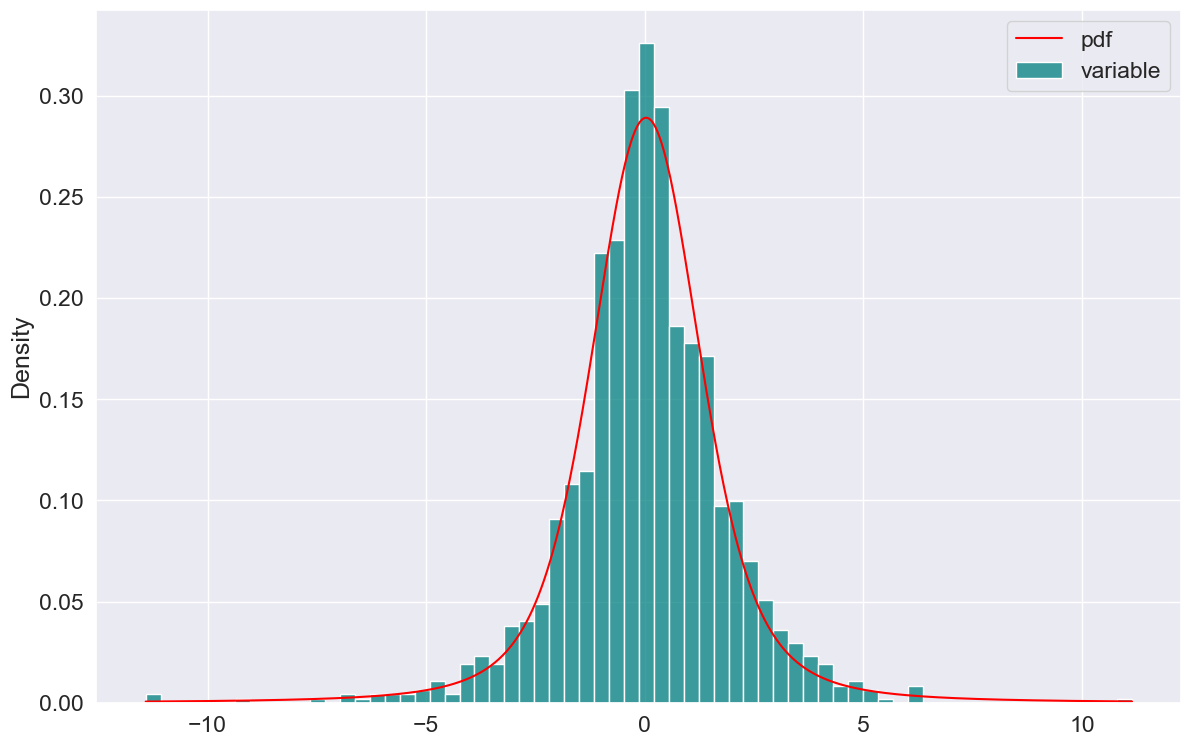

In [37]:
compare_pdf(date, data, stable_rv(date, data), color=colors["gbp"])

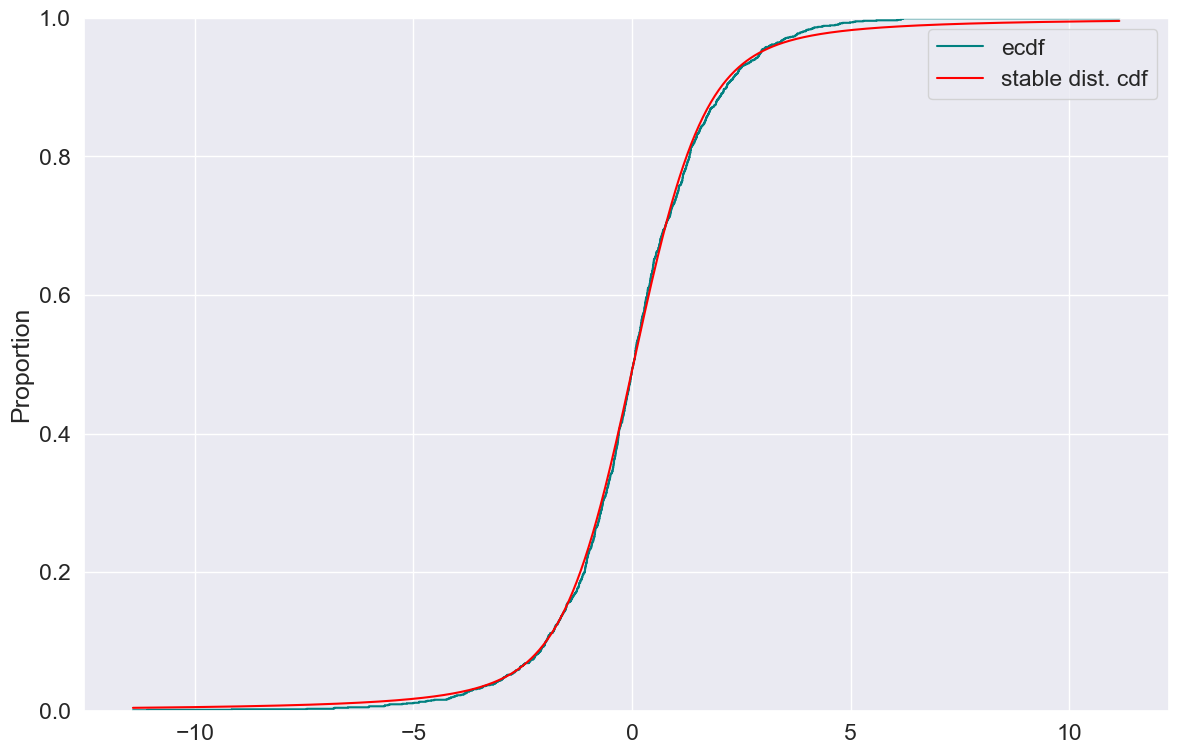

In [38]:
compare_cdf(date, data, stable_rv(date, data), color=colors["gbp"], 
            label2="stable dist. cdf")

In [39]:
measures(date, data, stable_rv(date, data))

### Basic measures
| measure   |   nonparametric |   parametric |
|:----------|----------------:|-------------:|
| mean      |       0.0403313 |    0.0323574 |
| std       |       1.828     |  inf         |
| median    |       0.0307258 |    0.0257898 |
| iqr       |       1.9165    |    1.91513   |
### Quantiles
|    q |   nonparametric |   parametric |
|-----:|----------------:|-------------:|
| 0.05 |      -2.87314   |   -2.86087   |
| 0.1  |      -1.9588    |   -1.96776   |
| 0.5  |       0.0307258 |    0.0257898 |
### CDF values
|   R_q |   nonparametric |   parametric |
|------:|----------------:|-------------:|
|    -1 |        0.225923 |     0.2347   |
|     0 |        0.492397 |     0.490841 |
|     1 |        0.739319 |     0.75223  |


<h2 style="text-align:center;">Multivariate analysis</h2>

In [40]:
petrol = pd.read_csv(os.path.join('data', 'fit', 'petrol_fit.csv'))
diesel = pd.read_csv(os.path.join('data', 'fit', 'diesel_fit.csv'))
gbp = pd.read_csv(os.path.join('data', 'fit', 'gbp_fit.csv'))
eur = pd.read_csv(os.path.join('data', 'fit', 'eur_fit.csv'))

In [41]:
prop = pd.read_csv(os.path.join('data', 'utils', 'proportion.csv'))

In [42]:
petrol_weight = prop.petrol.at[0]
diesel_weight = prop.diesel.at[0]
gbp_weight = prop.gbp.at[0]
eur_weight = prop.eur.at[0]

In [57]:
class MultivariateRisk:

    def __init__(self, dates, prices, weights, names):

        self.dates = pd.to_datetime(dates)
        self.prices = np.array(prices)
        self.returns = list(map(self.log_returns, self.prices))
        self.weights = np.array(weights)
        self.names = names
        self.portfolio = self.weighted_risk()
        self.rv = self.stable(self.portfolio)

    def log_returns(self, prices):

        return np.log(prices[1:] / prices[:-1]) / ((np.diff(self.dates) // (3600 * 24 * 10e8)).astype(float) / 365)

    @staticmethod
    def stable(data):

        pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
        alpha, beta, loc, scale = pconv(*stats.levy_stable._fitstart(data))

        return stats.levy_stable(alpha = alpha, beta = beta, loc = loc, scale = scale)

    def weighted_risk(self):

        return self.weights @ self.returns

    def deviation(self):

        return np.std(self.portfolio)

    def kde(self, xlim, ylim):

        fig, ax = plt.subplots(1, 1)
        cmap = plt.get_cmap("Purples")

        sns.kdeplot(x=self.returns[0], y=self.returns[1], cmap=cmap, fill=True, cbar=True)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(f'{self.names[0]}')
        ax.set_ylabel(f'{self.names[1]}')        
        
        fig.suptitle('2D empirical distribution of logarithmic returns')

        return ax

    def quantile(self, alpha=.05):

        return {'parametric': self.rv.ppf(1-alpha), 'nonparametric': np.quantile(self.portfolio, 1-alpha)}

    @staticmethod
    def binsearch(data, value):
        
        sorted_data = sorted(data)

        left = 0
        right = len(sorted_data) - 1
        while right - left > 1:
            midpoint = (right + left) // 2
            if sorted_data[midpoint] <= value:
                left = midpoint
            else:
                right = midpoint
        
        return left

    def cdf(self, returns):
        
        ecdf = lambda x: self.binsearch(self.portfolio, x) / len(self.portfolio)

        fig, ax = plt.subplots(1, 1, sharey=True)
        sns.lineplot(x=returns, y=np.vectorize(ecdf)(returns), ax=ax, label='nonparametric')
        sns.lineplot(x=returns, y=np.vectorize(self.rv.cdf)(returns), ax=ax, label='parametric')

        ax.legend()
        ax.set_xlabel('Log returns')
        ax.set_ylabel('CDF')
        fig.suptitle('Empirical CDF of logarithmic returns')

        return ax

    def spatial_cdf(self, returns_first, returns_second, ticks=11):

        ecdf = lambda x, y: self.binsearch(self.returns[0], x) * self.binsearch(self.returns[1], y) / \
                            (len(self.returns[0]) * len(self.returns[1]))

        nonparametric = np.vectorize(ecdf, signature='(),()->()')(returns_first, returns_second.reshape(-1, 1))

        fig, ax = plt.subplots(1, 1)
        cmap = plt.get_cmap("Purples")
        sns.heatmap(nonparametric, ax=ax, cmap=cmap, vmin=0, vmax=1)

        ax.set_xlabel(f'{self.names[0]} log returns')
        ax.set_ylabel(f'{self.names[1]}')
        ax.set_xticks(np.arange(1, len(returns_first), np.ceil(len(returns_first) / ticks)))
        ax.set_yticks(np.arange(1, len(returns_second), np.ceil(len(returns_second) / ticks)))
        ax.set_xticklabels(np.linspace(min(returns_first), max(returns_first), ticks).round(2))
        ax.set_yticklabels(np.linspace(min(returns_second), max(returns_second), ticks).round(2))

        fig.suptitle('Empirical CDF of logarithmic returns')

        return ax   

<h3 style="text-align:center;">Risk for petrol prices</h3>

In [58]:
fuel_risk = MultivariateRisk(petrol.date,
                             (petrol.price, diesel.price),
                             (petrol_weight, diesel_weight),
                             ('benzyna', 'diesel'))

In [59]:
fuel_risk.deviation()

2.2005650689038836

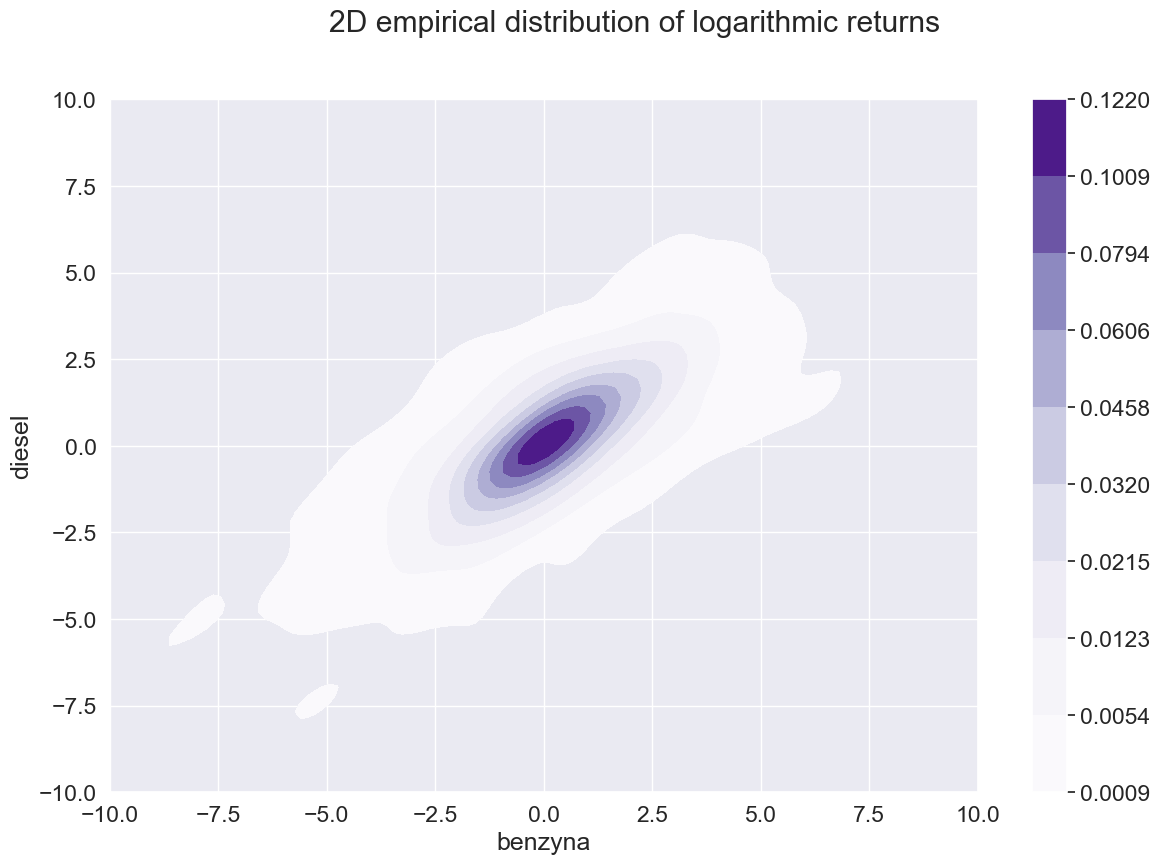

In [61]:
fuel_risk.kde((-10, 10), (-10, 10))
plt.show()

In [62]:
fuel_risk.quantile(alpha=0.1)

{'parametric': 2.0095826324008206, 'nonparametric': 2.1068924374771707}

In [63]:
fuel_risk.quantile(0.9)

{'parametric': -1.8283631275010406, 'nonparametric': -1.9123659961133623}

In [64]:
returns = np.linspace(-5, 5, 201)

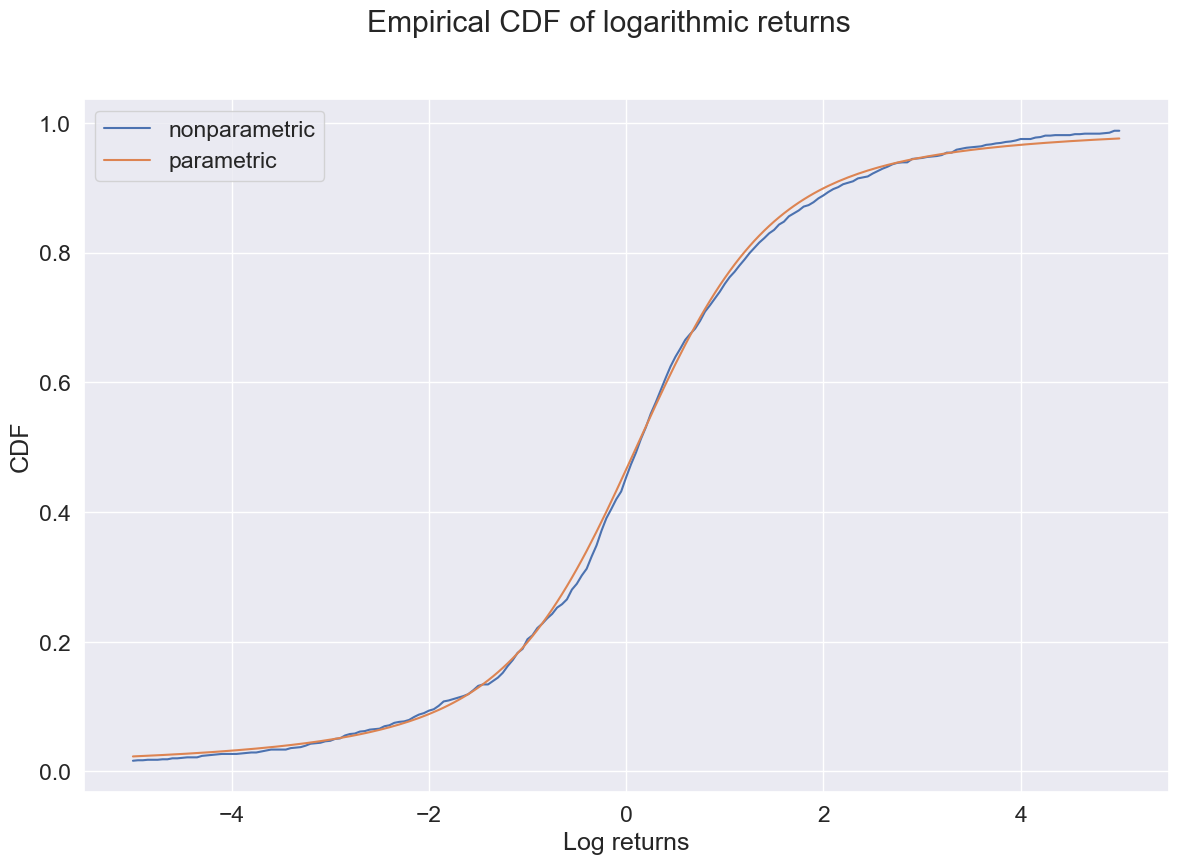

In [65]:
fuel_risk.cdf(returns)
plt.show()

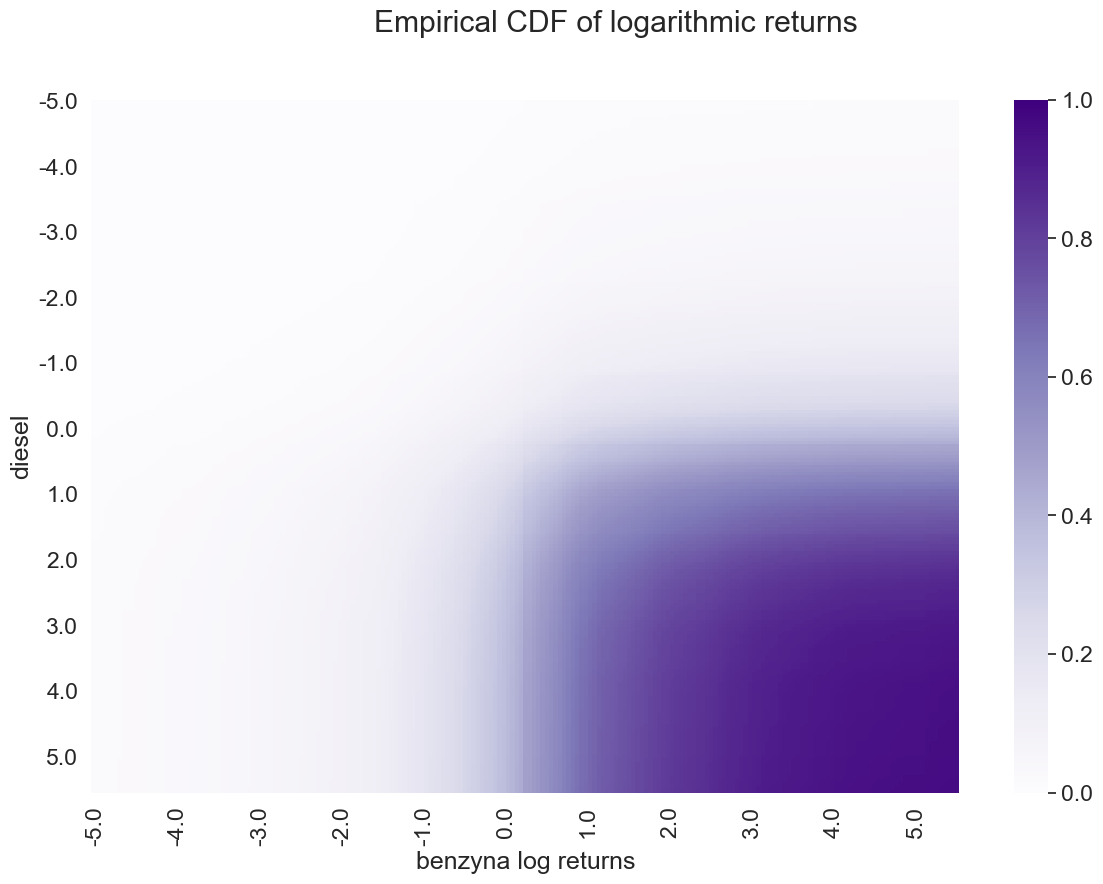

In [67]:
fuel_risk.spatial_cdf(returns, returns)
plt.show()

<h3 style="text-align:center;">Currency risk</h3>

In [68]:
currency_risk = MultivariateRisk(gbp.Date,
                                 (gbp.Open, eur.Open),
                                 (gbp_weight, eur_weight),
                                 ('GBP', 'EUR'))

In [69]:
currency_risk.deviation()

1.1820753144559513

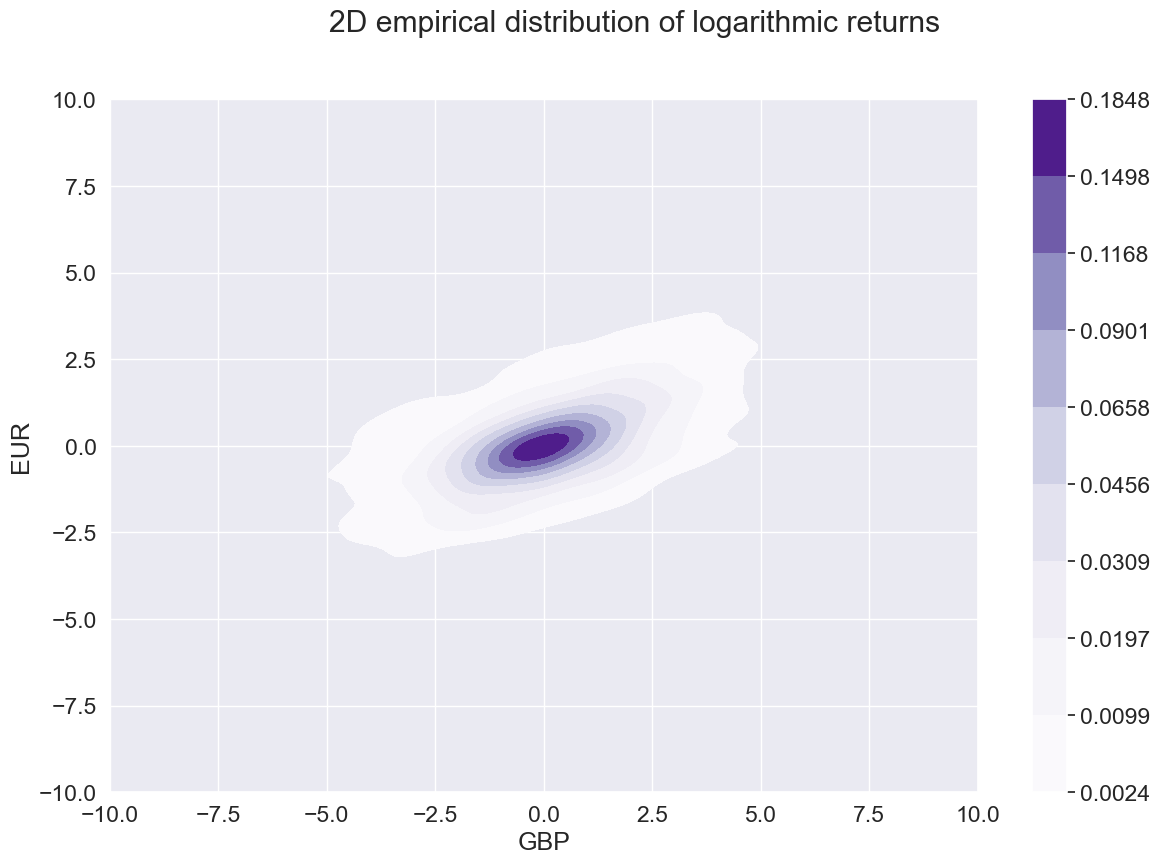

In [70]:
currency_risk.kde((-10, 10), (-10, 10))
plt.show()

In [71]:
currency_risk.quantile(0.1)

{'parametric': 1.267521600065731, 'nonparametric': 1.3582905249492232}

In [72]:
returns = np.linspace(-10, 10, 201)

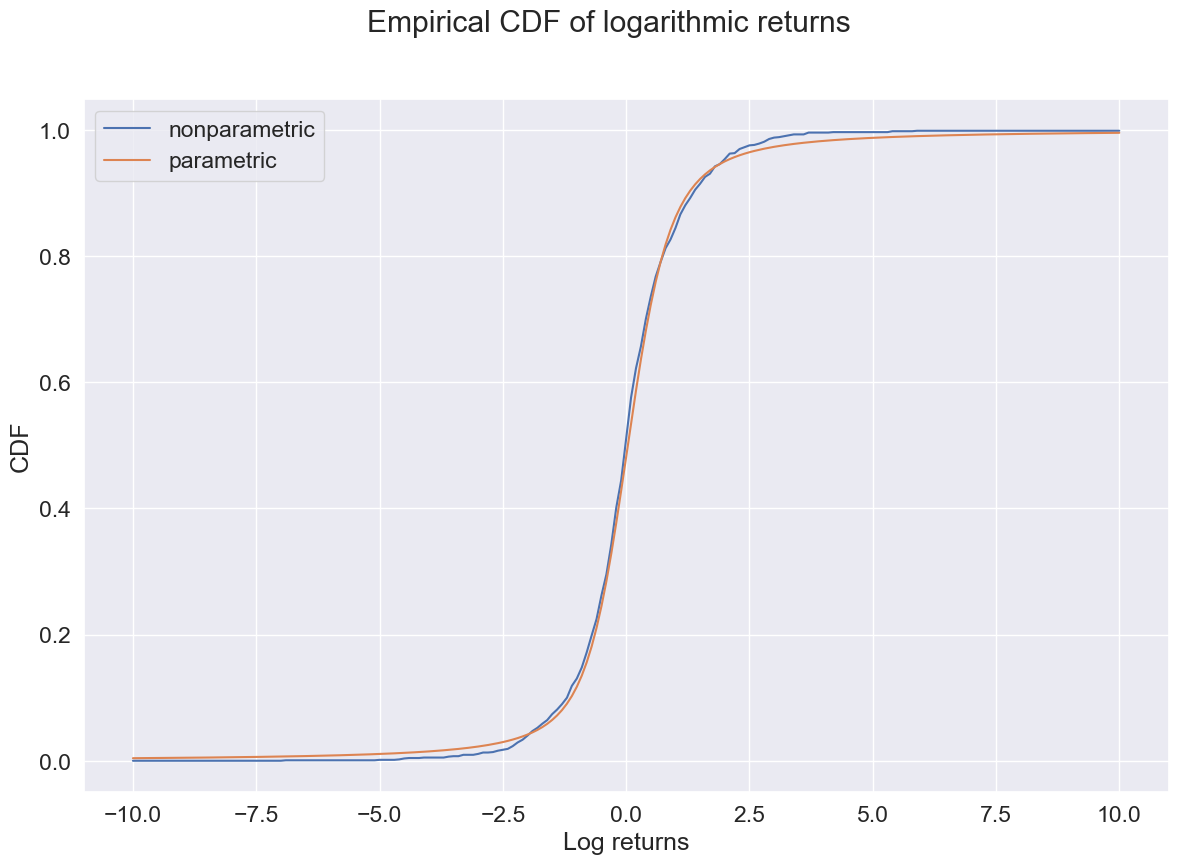

In [74]:
currency_risk.cdf(returns)
plt.show()

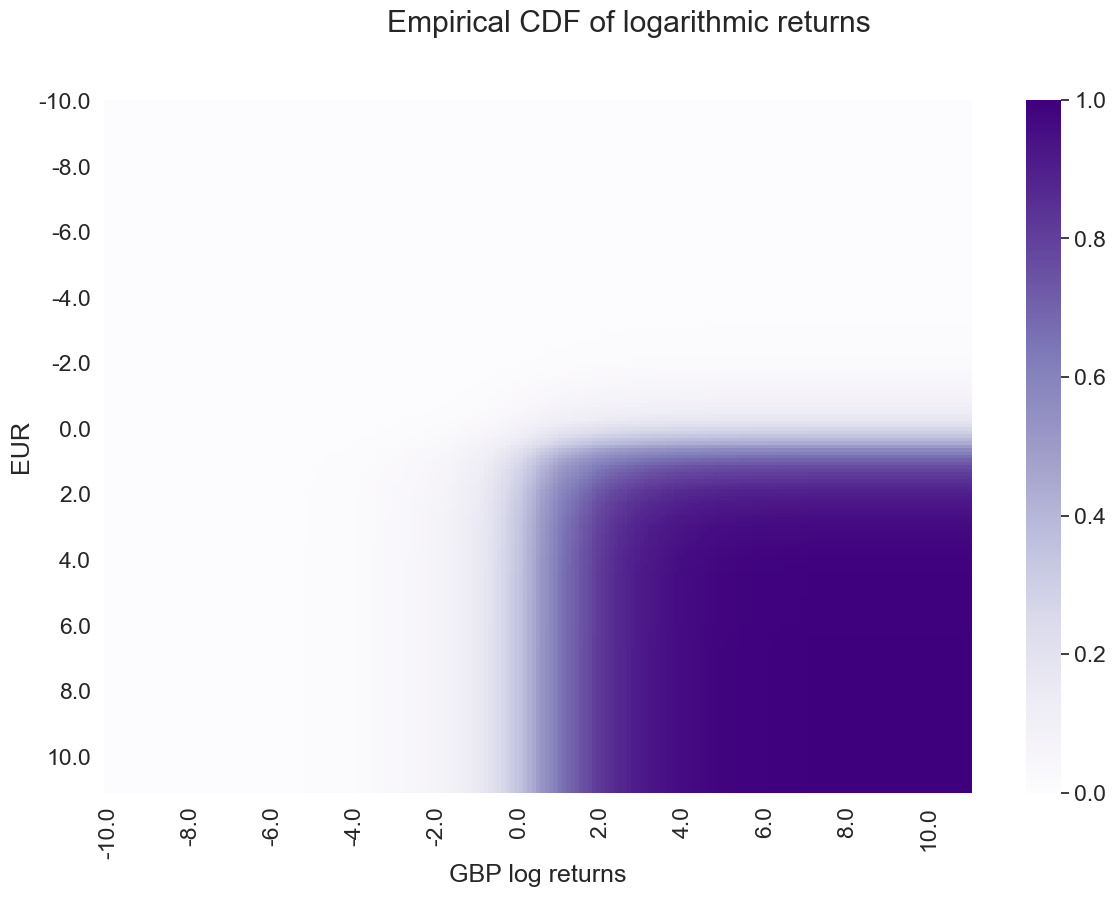

In [75]:
currency_risk.spatial_cdf(returns, returns)
plt.show()

<h2 style="text-align:center;">Backtesting</h2>

In [16]:
ftest_tuple = namedtuple('FtestResult', 'statistic pvalue')

In [17]:
# data loading and processing section
def load_data(test_or_fit, source):
    if source in ["diesel", "petrol"]:
        return pd.read_csv(os.path.join("data", f"{test_or_fit}", f"{source}_{test_or_fit}.csv"))[["price", "date"]]
    return pd.read_csv(
        os.path.join("data", f"{test_or_fit}", f"{source}_{test_or_fit}.csv"),
        header=0,
        names=["date", "price", "High", "Low", "Close", "Adj Close", "Volume"])[["price", "date"]]


def log_returns(data):
    date = pd.to_datetime(data["date"]).to_numpy(dtype='datetime64[D]')
    prices = data["price"].to_numpy()
    diff = np.diff(date).astype('float64')
    return np.diff(np.log(prices)) / (diff / 365.25) 


def get_log_returns_from_data(test_or_fit, source):
    return log_returns(load_data(test_or_fit, source))


# variance section
def ftest(X, Y):
    freedom_degress = map(lambda x: len(x) - 1, [X, Y])
    variances = map(lambda x: np.var(x, ddof=1), [X, Y])
    test_inputs = [(x, y) for (x, y) in sorted(zip(freedom_degress, variances), key=lambda z: z[1])]
    f_statistic = test_inputs[1][1] / test_inputs[0][1]
    p = 1 - stats.f.cdf(f_statistic, test_inputs[1][0], test_inputs[0][0])
    return ftest_tuple(f_statistic, p)


tests = [ftest, levene, bartlett, fligner]
def backtest_std(test_data, fit_data):
    return dict(zip(["F-test", "Levene", "Bartlett", "Fligner-Killeen"], map(lambda x: x(test_data, fit_data).pvalue, tests)))


# quantiles section
def backtest_quantile(alpha, data, window):
    n = len(data) - window - 1
    results = np.zeros(n)
    for i in range(n):
        results[i] = data[window+i+1] < np.quantile(data[i:window+i], alpha)
    return results


def backtest_quantile_verification(alpha, data, window=365):
    backtest_results = backtest_quantile(alpha, data, window)
    mean_, var_ = np.mean(backtest_results), np.var(backtest_results, ddof=1)
    return {"Mean from backtesting": mean_, "Theoretical mean": alpha,
            "Variance from backtesing": var_, "Theoretical variance": alpha * (1 - alpha)}  


# results printing
def markdown_table_printer(dictionary):
    s = pd.DataFrame(dictionary, index=[0]).to_markdown()
    return '\n'.join(map(lambda x: x[5:], s.split("\n")))

In [18]:
# std
for i in ["diesel", "petrol", "eur", "gbp"]:
    results = backtest_std(get_log_returns_from_data("test", i), 
                           get_log_returns_from_data("fit", i))
    print(i.upper())
    print(markdown_table_printer(results))
    print("\n")

DIESEL
|      F-test |      Levene |    Bartlett |   Fligner-Killeen |
|------------:|------------:|------------:|------------------:|
| 1.11022e-16 | 0.000187056 | 5.49402e-45 |         0.0203136 |


PETROL
|      F-test |    Levene |    Bartlett |   Fligner-Killeen |
|------------:|----------:|------------:|------------------:|
| 1.69864e-13 | 0.0151099 | 3.38342e-13 |          0.167205 |


EUR
|      F-test |      Levene |    Bartlett |   Fligner-Killeen |
|------------:|------------:|------------:|------------------:|
| 3.53346e-10 | 1.19946e-07 | 7.09041e-10 |       2.38086e-08 |


GBP
|      F-test |      Levene |    Bartlett |   Fligner-Killeen |
|------------:|------------:|------------:|------------------:|
| 3.92035e-09 | 1.90351e-06 | 7.86516e-09 |        2.0259e-06 |




In [19]:
np.random.seed(42)
X = stats.norm(loc=0, scale=4).rvs(100)
Y = stats.norm(loc=0, scale=2).rvs(100)
tests_results = backtest_std(X, Y)
print(markdown_table_printer(tests_results))

|      F-test |      Levene |    Bartlett |   Fligner-Killeen |
|------------:|------------:|------------:|------------------:|
| 2.96966e-10 | 1.30843e-07 | 5.95705e-10 |       5.57308e-07 |


In [20]:
np.random.seed(42)
X = stats.norm(loc=0, scale=4).rvs(100)
Y = stats.norm(loc=0, scale=4).rvs(100)
tests_results = backtest_std(X, Y)
print(markdown_table_printer(tests_results))

|   F-test |   Levene |   Bartlett |   Fligner-Killeen |
|---------:|---------:|-----------:|------------------:|
| 0.313805 | 0.671505 |   0.627608 |          0.742111 |


In [21]:
# quantiles
alphas = [0.05, 0.1, 0.5]

for alpha in alphas:
    print(f"# {alpha}")
    for i in ["diesel", "petrol", "eur", "gbp"]:
        print(f"## {i.upper()}")
        result = backtest_quantile_verification(alpha, get_log_returns_from_data("test", i))
        print(markdown_table_printer(result))
        print("\n")

# 0.05
## DIESEL
|   Mean from backtesting |   Theoretical mean |   Variance from backtesing |   Theoretical variance |
|------------------------:|-------------------:|---------------------------:|-----------------------:|
|               0.0529279 |               0.05 |                  0.0501831 |                 0.0475 |


## PETROL
|   Mean from backtesting |   Theoretical mean |   Variance from backtesing |   Theoretical variance |
|------------------------:|-------------------:|---------------------------:|-----------------------:|
|               0.0495495 |               0.05 |                  0.0471475 |                 0.0475 |


## EUR
|   Mean from backtesting |   Theoretical mean |   Variance from backtesing |   Theoretical variance |
|------------------------:|-------------------:|---------------------------:|-----------------------:|
|               0.0522388 |               0.05 |                  0.0495628 |                 0.0475 |


## GBP
|   Mean from backtesting 